### Setup

In [1]:
library(data.table)
library(dplyr)
library(ggplot2)


Attaching package: ‘dplyr’


The following objects are masked from ‘package:data.table’:

    between, first, last


The following objects are masked from ‘package:stats’:

    filter, lag


The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union




In [2]:
setwd('/exports/cmvm/eddie/smgphs/groups/Quantgen/Users/vasilis/PHD/EBB_methylation/')

In [3]:
## load results
all   <- fread('MWAS/EBB.BRAIN.METHYL.ALL.profile')
herit <- fread('MWAS/EBB.BRAIN.METHYL.HERIT.profile')

In [4]:
## load indep 
indep <- fread('tensorqtl/results/EBB.cis_qtl_indep.csv')

In [5]:
## process
bonf   <- 0.05 /nrow(all)

all_info <- 
all %>%
    filter(hsq > 0 & hsq < 1) %>%
    mutate(
        # fdr q-value
        fdr = p.adjust(hsq.pv, method = 'fdr'),
        # indep mCpG yes / no
        mcpg = ifelse(id %in% indep$phenotype_id, 'yes', 'no'),
        # signif yes / no
        sig_bonf = ifelse(hsq.pv < bonf, 'yes', 'no'),
        sig_fdr = ifelse(fdr < 0.05, 'yes', 'no'),
        # pv < 0.05 & cv.r2 > 0.01 yes / no
        herit = ifelse(id %in% herit$id, 'yes', 'no')
    )

dim(all_info)
head(all_info,3)


[1] 393901     20

id,nsnps,hsq,hsq.se,hsq.pv,top1.r2,blup.r2,enet.r2,bslmm.r2,lasso.r2,top1.pv,blup.pv,enet.pv,bslmm.pv,lasso.pv,fdr,mcpg,sig_bonf,sig_fdr,herit
<chr>,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<lgl>,<dbl>,<lgl>,<dbl>,<dbl>,<lgl>,<dbl>,<lgl>,<dbl>,<dbl>,<chr>,<chr>,<chr>,<chr>
cg20544410,236,0.038,0.073,0.260,-0.003,NA,0.013,NA,0.053,0.45,NA,0.11,NA,0.0057,0.3745703,no,no,no,no
cg00103671,563,0.059,0.094,0.200,-0.008,NA,-0.003,NA,-0.005,0.93,NA,0.42,NA,0.5700,0.3311929,no,no,no,no
cg13526636,543,0.130,0.120,0.075,0.002,NA,0.009,NA,0.001,0.26,NA,0.15,NA,0.2900,0.1988007,no,no,no,no


In [6]:
## h2 significance
all_info %>% group_by(mcpg) %>% summarise(n=n())
all_info %>% group_by(sig_fdr) %>% summarise(n=n())
n_fdr = nrow(all_info[all_info$sig_fdr=='yes',])
pct_fdr = (n_fdr / nrow(all_info))*100
cat(paste0(n_fdr,' CpG sites with fdr signif h^2 ', "(", round(pct_fdr,1), "%)"))

all_info %>% group_by(mcpg, sig_bonf) %>% summarise(n=n())
all_info %>% group_by(mcpg, sig_fdr) %>% summarise(n=n())
all_info %>% group_by(mcpg, herit) %>% summarise(n=n())


mcpg,n
<chr>,<int>
no,307924
yes,85977


sig_fdr,n
<chr>,<int>
no,315043
yes,78858


78858 CpG sites with fdr signif h^2 (20%)

`summarise()` has grouped output by 'mcpg'. You can override using the `.groups` argument.


mcpg,sig_bonf,n
<chr>,<chr>,<int>
no,no,307924
yes,no,66957
yes,yes,19020


`summarise()` has grouped output by 'mcpg'. You can override using the `.groups` argument.


mcpg,sig_fdr,n
<chr>,<chr>,<int>
no,no,292964
no,yes,14960
yes,no,22079
yes,yes,63898


`summarise()` has grouped output by 'mcpg'. You can override using the `.groups` argument.


mcpg,herit,n
<chr>,<chr>,<int>
no,no,275940
no,yes,31984
yes,no,11996
yes,yes,73981


In [7]:
#install.packages('ggbreak')

ggbreak v0.1.6 Learn more at https://yulab-smu.top/



If you use ggbreak in published research, please cite the following paper:

S Xu, M Chen, T Feng, L Zhan, L Zhou, G Yu. Use ggbreak to effectively utilize plotting space to deal with large datasets and outliers. Frontiers in Genetics. 2021, 12:774846.
doi: 10.3389/fgene.2021.774846 

Saving 7 x 7 in image
Saving 7 x 7 in image


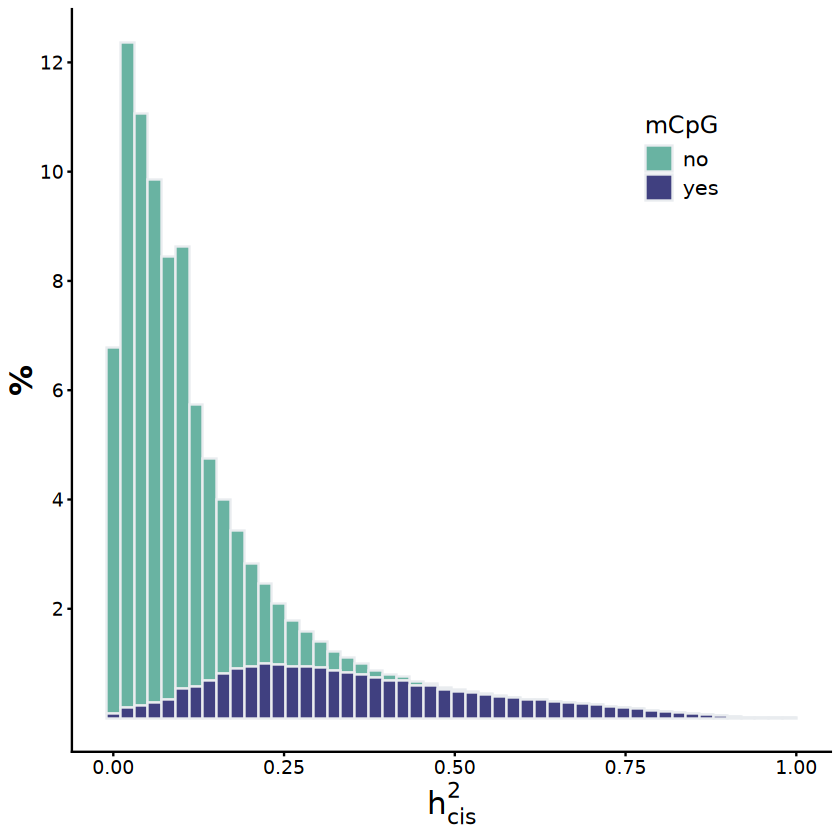

In [8]:
## plot
library(ggbreak) 
library(ggpubr)
library(scales)

# break1 = 12 
# break2 = 45

# source data
p1_source_data <- all_info %>% select(id, hsq, hsq.pv, mcpg, sig_bonf, sig_fdr)

p1 <-
ggplot(data = p1_source_data, aes(x=hsq, fill=mcpg)) +
    geom_histogram(bins = 50, aes(y = after_stat(100*count / sum(count))), color="#e9ecef", alpha=1, position = 'stack') +
    theme_classic() + 
    # fill colors 
    scale_fill_manual(values=c("#69b3a2", "#404080")) +
    # truncate y axis 
    # scale_y_break(breaks = c(break1, break2)) +
    # customise y axis breaks
    scale_y_continuous(breaks = seq(2,48,2)) + 
    # remove right y axis
    theme(
        axis.text.y.right = element_blank(),
        axis.line.y.right = element_blank(),
        axis.ticks.y.right = element_blank()
    ) +
    # costumise axis labs
    labs(x = expression(paste(h[cis]^2)), 
         y = "%", 
         fill="mCpG") +
    theme(
        axis.title = element_text(face = 'bold', size=18),
        axis.text.y.left =element_text(size=11),
        axis.text.x =element_text(size=11)
    ) +
    # legend
    theme(
        legend.title = element_text(size=14),
        legend.text  = element_text(size=12),
        legend.position = "inside",
        legend.position.inside = c(0.8, 0.8)
    )
p1 

# save
ggsave('plots/heritabilty_v2_hist.png', p1, dpi=600)
ggsave('plots/heritabilty_v2_hist.pdf', p1, dpi=600)
fwrite(p1_source_data, 'plots/heritabilty_v2_hist_sourcedata.csv')

Saving 7 x 7 in image
Saving 7 x 7 in image


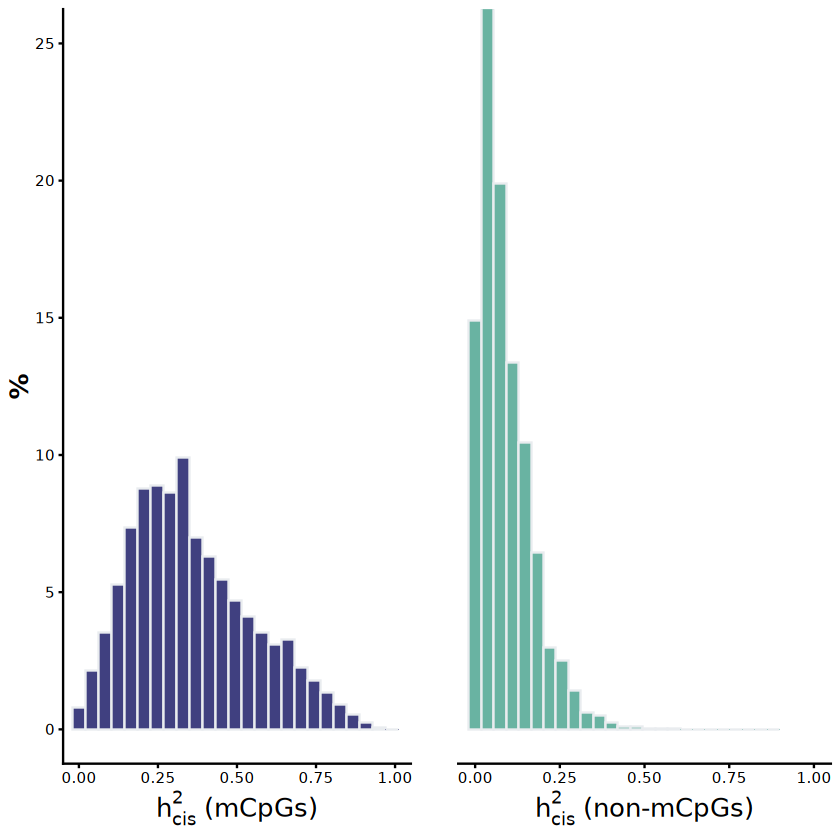

In [9]:
p2a <- 
ggplot(data = p1_source_data[p1_source_data$mcpg=='yes',], aes(x=hsq)) +
    geom_histogram(bins = 25, aes(y = after_stat(100*count / sum(count))), color="#e9ecef", alpha=1, fill = '#404080') +
    theme_classic() + 
    # remove right y axis
    theme(
        axis.text.y.right = element_blank(),
        axis.line.y.right = element_blank(),
        axis.ticks.y.right = element_blank()
    ) +
    labs(x = expression(paste(h[cis]^2, ' (mCpGs)')), 
         y = "%"
        ) +
    theme(axis.title = element_text(face = 'bold', size=15)) +
    # axis limits
    coord_cartesian(ylim = c(0,25), xlim = c(0,1))
p2b <-
ggplot(data = p1_source_data[p1_source_data$mcpg=='no',], aes(x=hsq)) +
    geom_histogram(bins = 25, aes(y = after_stat(100*count / sum(count))), color="#e9ecef", alpha=1, fill = '#69b3a2') +
    theme_classic() + 
    # remove right y axis
    theme(
        axis.text.y = element_blank(),
        axis.line.y = element_blank(),
        axis.ticks.y = element_blank()
    ) +
    labs(x = expression(paste(h[cis]^2, ' (non-mCpGs)')), 
         y = ""
        ) +
    theme(axis.title = element_text(face = 'bold', size=15)) +
    # axis limits
    coord_cartesian(ylim = c(0,25), xlim = c(0,1))
p2 <- ggarrange(p2a, p2b)
p2

ggsave('plots/heritabilty_hist_split_v2.png', p2, dpi = 600)
ggsave('plots/heritabilty_hist_split_v2.pdf', p2, dpi = 600)


Saving 7 x 7 in image
Saving 7 x 7 in image


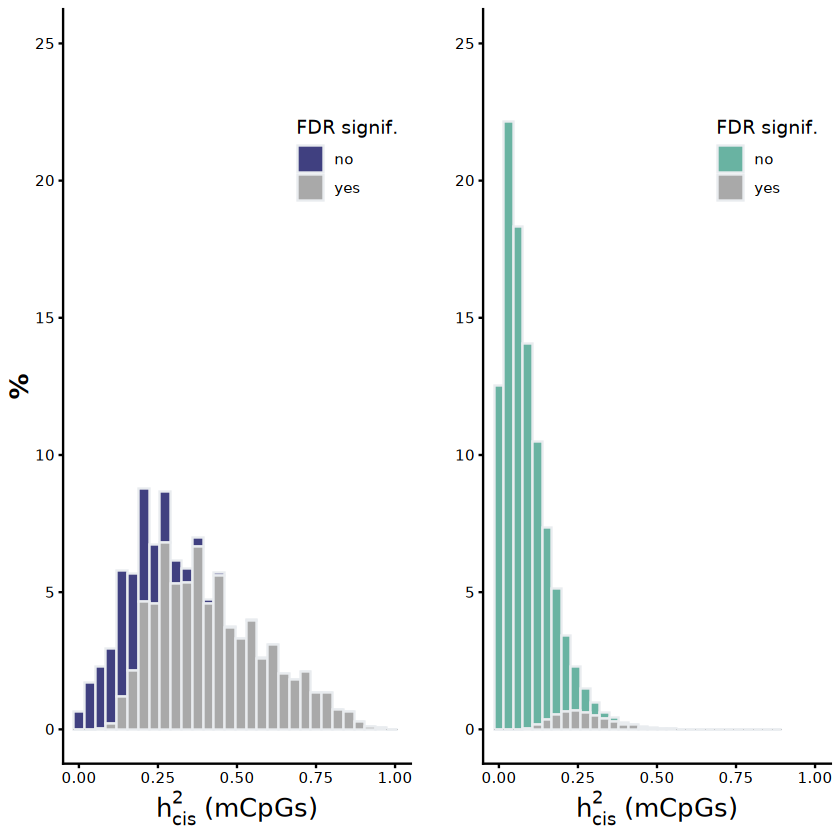

In [10]:
p3a <- 
ggplot(data = p1_source_data[p1_source_data$mcpg=='yes',], aes(x=hsq, fill=as.factor(sig_fdr))) +
    geom_histogram(bins = 30, aes(y = after_stat(100*count / sum(count))), color="#e9ecef", alpha=1, position = 'stack') +
    theme_classic() + 
    # fill colors 
    scale_fill_manual(values=c("#404080", "darkgrey")) +
    # remove right y axis
    theme(
        axis.text.y.right = element_blank(),
        axis.line.y.right = element_blank(),
        axis.ticks.y.right = element_blank()
    ) +
    labs(x = expression(paste(h[cis]^2, ' (mCpGs)')), 
         y = "%",
         fill = 'FDR signif.'
        ) +
    theme(axis.title = element_text(face = 'bold', size=15)) +
    # axis limits
    coord_cartesian(ylim = c(0,25), xlim = c(0,1)) +
    # legend
    theme(
        #legend.title = element_text(size=12),
        #legend.text  = element_text(size=12),
        legend.position = "inside",
        legend.position.inside = c(0.8, 0.8)
    )
p3b <- 
ggplot(data = p1_source_data[p1_source_data$mcpg=='no',], aes(x=hsq, fill=as.factor(sig_fdr))) +
    geom_histogram(bins = 30, aes(y = after_stat(100*count / sum(count))), color="#e9ecef", alpha=1, position = 'stack') +
    theme_classic() + 
    # fill colors 
    scale_fill_manual(values=c("#69b3a2", "darkgrey")) +
    # remove right y axis
    theme(
        axis.text.y.right = element_blank(),
        axis.line.y.right = element_blank(),
        axis.ticks.y.right = element_blank()
    ) +
    labs(x = expression(paste(h[cis]^2, ' (mCpGs)')), 
         y = "",
         fill = 'FDR signif.'
        ) +
    theme(axis.title = element_text(face = 'bold', size=15)) +
    # axis limits
    coord_cartesian(ylim = c(0,25), xlim = c(0,1)) +
    # legend
    theme(
        #legend.title = element_text(size=12),
        #legend.text  = element_text(size=12),
        legend.position = "inside",
        legend.position.inside = c(0.8, 0.8)
    )
p3 <- ggarrange(p3a, p3b, common.legend = FALSE)
p3

ggsave('plots/heritabilty_hist_split_h2sig_v2.png', p3, dpi = 600)
ggsave('plots/heritabilty_hist_split_h2sig_v2.pdf', p3, dpi = 600)
